In [12]:
# --- Manipulación de datos ---
import pandas as pd
import numpy as np
import itertools
from IPython.display import display

# --- Estadística y modelos ---
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from linearmodels.panel import PanelOLS

# --- Visualización ---
import matplotlib.pyplot as plt

# --- Mapas ---
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import webbrowser

In [13]:
data = "Afluencia mensual metro.xlsx"
hojas = pd.read_excel(data, sheet_name=None)
print(hojas[list(hojas.keys())[0]].columns.tolist())
print(hojas[list(hojas.keys())[0]].columns.tolist())

mapa_estaciones = {
    "ACE": "ACEVEDO",
    "BEO": "BELLO",
    "NIQ": "NIQUIA",
    "XPO": "EXPOSICIONES",
    "JAV": "SAN JAVIER",
    "SAM": "SURAMERICANA",
    "HOS": "HOSPITAL",
    "UNI": "UNIVERSIDAD",
    "LUC": "SANTA LUCIA",
    "FLO": "FLORESTA",
    "EST": "ESTADIO",
    "STA": "LA ESTRELLA",
    "BAN": "SABANETA",
    "ITA": "ITAGUI",
    "CIS": "CISNEROS",
    "AYU": "AYURA",
    "SAA": "SAN ANTONIO",
    "ALP": "ALPUJARRA",
    "TRI": "TRICENTENARIO",
    "CAR": "CARIBE",
    "MAD": "MADERA",
    "BER": "PARQUE BERRIO",
    "PRA": "PRADO",
    "POB": "POBLADO",
    "IND": "INDUSTRIALES",
    "CAT": "AGUACATALA",
    "ENV": "ENVIGADO",
}

# Seleccionar la primera hoja como df
df = hojas[list(hojas.keys())[0]]

df = df.rename(columns=mapa_estaciones)

print(df.columns.tolist())
dfs = []

for nombre_hoja, df in hojas.items():
    try:
        # Suponemos que el nombre de la hoja es el año
        año = int(nombre_hoja)
    except ValueError:
        print(f"⚠️ Hoja {nombre_hoja} ignorada (no es un año)")
        continue

    # --- LIMPIAMOS LOS NOMBRES DE COLUMNAS ---
    df.columns = df.columns.astype(str).str.strip()  # quita espacios

    # Renombrar variantes de Estación a "ESTACION"
    posibles_nombres = ["Estación", "ESTACION", "Estacion", "estacion"]
    for col in posibles_nombres:
        if col in df.columns:
            df = df.rename(columns={col: "ESTACION"})
            break

    if "ESTACION" not in df.columns:
        print(f"⚠️ Hoja {nombre_hoja} ignorada (no tiene columna ESTACION)")
        continue

    # Detectamos columnas de meses
    meses_presentes = [c for c in df.columns if c not in ["ESTACION", "Total"]]

    # Pasamos a formato largo
    df_long = df.melt(
        id_vars=["ESTACION"],
        value_vars=meses_presentes,
        var_name="Mes",
        value_name="Afluencia"
    )
    df_long["Año"] = año

    # --- LIMPIEZA + CAMBIO DE NOMBRES DE ESTACIONES ---
    df_long["ESTACION"] = df_long["ESTACION"].astype(str).str.strip()
    df_long["ESTACION"] = df_long["ESTACION"].replace(mapa_estaciones)

    dfs.append(df_long)

# --- 2. Unimos todo ---
data = pd.concat(dfs, ignore_index=True)
# --- 3. Mapear meses ---
mapa_meses = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}
data["Mes"] = data["Mes"].astype(str).str.strip()  # limpiar espacios
data["Mes_num"] = data["Mes"].map(mapa_meses)

# Si algún mes no se mapea, avisa
if data["Mes_num"].isna().any():
    print("⚠️ Hay meses no reconocidos en la columna 'Mes':")
    print(data.loc[data["Mes_num"].isna(), "Mes"].unique())

# --- 4. Fecha ---
data["Fecha"] = pd.to_datetime(dict(year=data["Año"], month=data["Mes_num"], day=1))

# --- 5. Agrupar por trimestre (con nombres completos de estación) ---
res = (
    data.groupby(["ESTACION", pd.Grouper(key="Fecha", freq="Q")], as_index=False)["Afluencia"]
    .agg(
        aprom="mean",
        asum="sum"
    )
)

# Crear columna AñoT en formato "YYYY-T"
res["AñoT"] = res["Fecha"].dt.year.astype(str) + "-" + res["Fecha"].dt.quarter.astype(str)

# Eliminar la columna Fecha y reordenar
res = res.drop(columns=["Fecha"])[
    ["ESTACION", "AñoT", "aprom", "asum"]
]

print(res.head(20))
res



['Estación', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Total']
['Estación', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Total']
['Estación', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Total']
⚠️ Hay meses no reconocidos en la columna 'Mes':
['Nombre' 'ENERO' 'FEBRERO' 'MARZO' 'ABRIL' 'MAYO' 'JUNIO' 'JULIO'
 'AGOSTO' 'SEPTIEMBRE' 'OCTUBRE' 'NOVIEMBRE' 'DICIEMBRE' 'TOTAL'
 'Unnamed: 14' 'Unnamed: 15' 'Unnamed: 16' 'Unnamed: 17' 'Unnamed: 18'
 'Unnamed: 19' 'Unnamed: 20' 'Unnamed: 21' 'Unnamed: 22' 'Unnamed: 23'
 'Unnamed: 24' 'Unnamed: 25' 'Unnamed: 26' 'Unnamed: 27' 'Unnamed: 28'
 'Unnamed: 29' 'Unnamed: 30' 'Unnamed: 31']
   ESTACION    AñoT          aprom     asum
0   ACEVEDO  2012-1  586976.666667  1760930
1   ACEVEDO  2012-2       591850.

C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_24240\2811105964.py:104: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.groupby(["ESTACION", pd.Grouper(key="Fecha", freq="Q")], as_index=False)["Afluencia"]


,ESTACION,AñoT,aprom,asum
0,ACEVEDO,2012-1,586976.666667,1760930
1,ACEVEDO,2012-2,591850.0,1775550
2,ACEVEDO,2012-3,617626.666667,1852880
3,ACEVEDO,2012-4,638917.666667,1916753
4,ACEVEDO,2013-1,586402.333333,1759207
...,...,...,...,...
1155,UNIVERSIDAD,2020-4,202522.666667,607568
1156,UNIVERSIDAD,2021-1,202577.333333,607732
1157,UNIVERSIDAD,2021-2,143254.0,429762.0
1158,UNIVERSIDAD,2021-3,222807.566667,668422.7


In [14]:

DatosV = pd.read_excel("C:/Users/Felipe Bañol/Documents/GitHub/Metro2.0/DatosV.xlsx")
DatosV["EDAD"] = pd.to_numeric(DatosV["EDAD"], errors="coerce")
DatosV = DatosV[DatosV["AñoT"] >= "2012-4"]
DatosV["ESTACION"] = DatosV["ESTACION"].replace({"SAN ANTONIO B": "SAN ANTONIO", "SAN JAVIER J": "SAN JAVIER"})
estaciones_validas = [
    "NIQUIA", "BELLO", "MADERA", "ACEVEDO", "TRICENTENARIO", "CARIBE", "UNIVERSIDAD",
    "HOSPITAL", "PRADO", "PARQUE BERRIO", "SAN ANTONIO", "ALPUJARRA", "EXPOSICIONES",
    "INDUSTRIALES", "POBLADO", "AGUACATALA", "AYURA", "ENVIGADO", "ITAGUI", "SABANETA", "LA ESTRELLA", "SAN JAVIER", "SANTA LUCIA", "FLORESTA","ESTADIO", "SURAMERICANA","CISNEROS"
]
DatosV = DatosV[DatosV["ESTACION"].isin(estaciones_validas)]

# --- Crear subconjuntos ---
DatosM = DatosV[DatosV["GENERO"] == "M"]
DatosF = DatosV[DatosV["GENERO"] == "F"]
Datos_joven = DatosV[DatosV["EDAD"] <= 28]
Datos_no_joven = DatosV[DatosV["EDAD"] > 28]
DatosM_joven = DatosV[(DatosV["GENERO"] == "M") & (DatosV["EDAD"] <= 28)]
DatosF_joven = DatosV[(DatosV["GENERO"] == "F") & (DatosV["EDAD"] <= 28)]
DatosM_no_joven = DatosV[(DatosV["GENERO"] == "M") & (DatosV["EDAD"] > 28)]
DatosF_no_joven = DatosV[(DatosV["GENERO"] == "F") & (DatosV["EDAD"] > 28)]
# --- Función para crear conteo ---
años = range(2012, 2024)
trimestres = [1, 2, 3, 4]
todos_trimestres = [f"{año}-{t}" for año, t in itertools.product(años, trimestres)]
estaciones = DatosV["ESTACION"].unique()
DatosV


,AñoT,ESTACION,EDAD,GENERO,Sobrevivencia
27,2013-2,ACEVEDO,25.0,M,1
28,2013-3,ACEVEDO,24.0,M,1
29,2013-4,ACEVEDO,21.0,M,1
30,2013-4,ACEVEDO,NaN,F,1
31,2014-1,ACEVEDO,17.0,M,1
...,...,...,...,...,...
1023,2023-4,UNIVERSIDAD,25.0,F,1
1027,2015-1,UNIVERSIDAD,15.0,F,0
1028,2020-1,UNIVERSIDAD,24.0,M,0
1029,2022-2,UNIVERSIDAD,24.0,M,0


In [15]:



# Diccionario de estaciones y coordenadas
coords = {
    "PARQUE BERRIO": "6.250462303868426,-75.56834000837911",
    "UNIVERSIDAD": "6.26915598179275,-75.5662274347604",
    "SAN ANTONIO": "6.247330146607752,-75.5698201061719",
    "ENVIGADO": "6.174812726117751,-75.59709553476108",
    "POBLADO": "6.213232150899053,-75.57825884840798",
    "EXPOSICIONES": "6.238530638603876,-75.57315109058204",
    "FLORESTA": "6.259010554943915,-75.59786716758109",
    "SANTA LUCIA": "6.258223202357437,-75.60379266359627",
    "CARIBE": "6.277550151742888,-75.56958369058172",
    "HOSPITAL": "6.263899800728917,-75.56357215935357",
    "PRADO": "6.257064210414861,-75.56626869254376",
    "ESTADIO": "6.2535260786987585,-75.58822609455328",
    "INDUSTRIALES": "6.23029508083824,-75.57564105085336",
    "NIQUIA": "6.338005305862645,-75.54419969058134",
    "ACEVEDO": "6.300269893042005,-75.55736196228843",
    "ALPUJARRA": "6.243329387661553,-75.57164971362404",
    "ANDALUCIA": "6.296434019608016,-75.55194856359589",
    "CISNEROS": "6.24908909785412,-75.57484417126771",
    "AYURA": "6.186664356406138,-75.58529863106094",
    "SAN JAVIER": "6.257070663629232,-75.61395739536867",
    "MADERA": "6.316095631702425,-75.5553866635958",
    "TRICENTENARIO": "6.290681332598884,-75.56480136755223",
    "BELLO": "6.33200105209788,-75.55382519499489",
    "SURAMERICANA": "6.253223323834436,-75.58307115195348",
    "ITAGUI": "6.164471586641053,-75.60668072502183",
    "AGUACATALA": "6.1940934008013615,-75.58185203078955",
    "SANTO DOMINGO": "6.29289386348335,-75.54182252280995",
    "SABANETA": "6.157505762419725,-75.6167022617469",
    "LA ESTRELLA": "6.152864366388068,-75.62647850592543",
    "PALMA": "6.231296651941057,-75.60103162165781",
    "AURORA": "6.281180272067294,-75.57300898767743",
    "BICENTENARIO": "6.244295592935814,-75.55876227264393",
    "MIRAFLORES": "6.241609163809552,-75.54900663476063",
    "ACEVEDO K": "6.300269893042005,-75.55736196228843",
    "SAN ANTONIO B": "6.247330146607752,-75.5698201061719"
}

# Crear nueva columna en la base de datos
DatosV["Coordenadas"] = DatosV["ESTACION"].map(coords).fillna(0)
# Primero agregamos la columna de coordenadas como antes
DatosV["Coordenadas"] = DatosV["ESTACION"].map(coords).fillna("0,0")

# Luego separamos en Latitud y Longitud
DatosV[["Latitud", "Longitud"]] = DatosV["Coordenadas"].str.split(",", expand=True)

# Convertir a tipo numérico (float)
DatosV["Latitud"] = DatosV["Latitud"].astype(float)
DatosV["Longitud"] = DatosV["Longitud"].astype(float)

# (Opcional) eliminar la columna original de texto
DatosV = DatosV.drop(columns=["Coordenadas"])
DatosV


,AñoT,ESTACION,EDAD,GENERO,Sobrevivencia,Latitud,Longitud
27,2013-2,ACEVEDO,25.0,M,1,6.300270,-75.557362
28,2013-3,ACEVEDO,24.0,M,1,6.300270,-75.557362
29,2013-4,ACEVEDO,21.0,M,1,6.300270,-75.557362
30,2013-4,ACEVEDO,NaN,F,1,6.300270,-75.557362
31,2014-1,ACEVEDO,17.0,M,1,6.300270,-75.557362
...,...,...,...,...,...,...,...
1023,2023-4,UNIVERSIDAD,25.0,F,1,6.269156,-75.566227
1027,2015-1,UNIVERSIDAD,15.0,F,0,6.269156,-75.566227
1028,2020-1,UNIVERSIDAD,24.0,M,0,6.269156,-75.566227
1029,2022-2,UNIVERSIDAD,24.0,M,0,6.269156,-75.566227


C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_24240\4062253573.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = DatosV.groupby(["EdadGrupo", "GENERO"]).size().reset_index(name="Total")
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_24240\4062253573.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(abs(int(x))) for x in xticks])


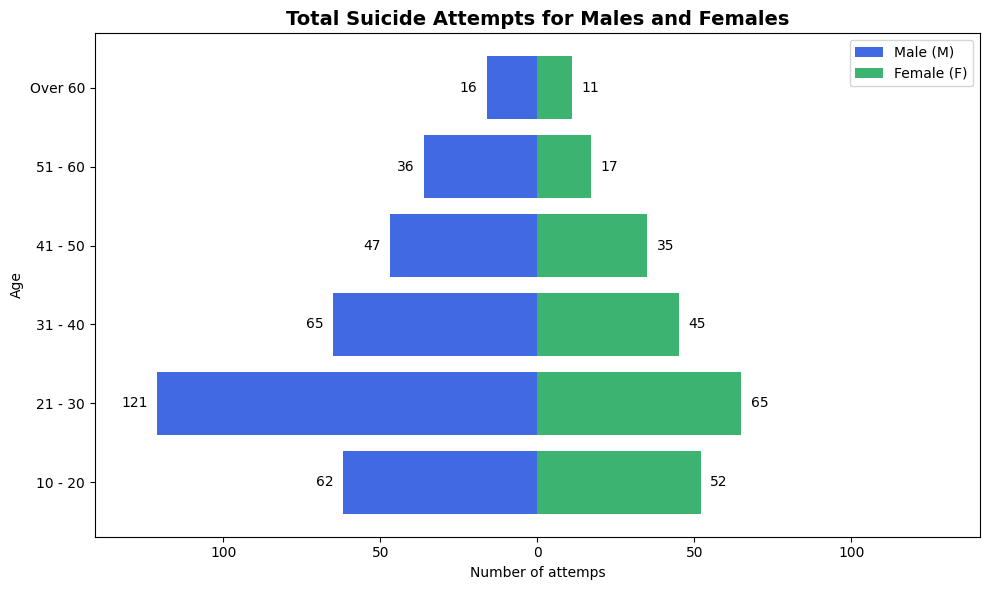

In [16]:
# --- 1. Crear rangos de edad ---
bins = [10, 20, 30, 40, 50, 60, 200]
labels = ["10 - 20", "21 - 30", "31 - 40", "41 - 50", "51 - 60", "Over 60"]

DatosV["EdadGrupo"] = pd.cut(DatosV["EDAD"], bins=bins, labels=labels, right=True)

# --- 2. Contar intentos por género y grupo etario ---
conteo = DatosV.groupby(["EdadGrupo", "GENERO"]).size().reset_index(name="Total")

# --- 3. Pivotear ---
tabla = conteo.pivot(index="EdadGrupo", columns="GENERO", values="Total").fillna(0)
tabla = tabla.reindex(columns=["M", "F"], fill_value=0)
tabla = tabla.reindex(labels)

# --- 4. Graficar pirámide ---
fig, ax = plt.subplots(figsize=(10,6))

# Hombres (M) a la izquierda → valores negativos
ax.barh(tabla.index, -tabla["M"], color="royalblue", label="Male (M)")

# Mujeres (F) a la derecha → valores positivos
ax.barh(tabla.index, tabla["F"], color="mediumseagreen", label="Female (F)")

# --- 5. Etiquetas en las barras (positivas) ---
for i, edad in enumerate(tabla.index):
    male_val = tabla["M"].iloc[i]
    female_val = tabla["F"].iloc[i]
    ax.text(-male_val-3, i, str(int(male_val)), va="center", ha="right", color="black")
    ax.text(female_val+3, i, str(int(female_val)), va="center", ha="left", color="black")

# --- 6. Eje X simétrico pero con etiquetas positivas ---
max_val = max(tabla.max())
ax.set_xlim(-max_val-20, max_val+20)

# Reemplazar las etiquetas negativas por positivas
xticks = ax.get_xticks()
ax.set_xticklabels([str(abs(int(x))) for x in xticks])

# --- 7. Estética ---
ax.set_title("Total Suicide Attempts for Males and Females", fontsize=14, weight="bold")
ax.set_xlabel("Number of attemps")
ax.set_ylabel("Age")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()



In [34]:
# Contar repeticiones de cada estación
conteo_estaciones = DatosV['ESTACION'].value_counts().sort_index()

# Crear DataFrame con frecuencia absoluta
df_frecuencia = conteo_estaciones.reset_index()
df_frecuencia.columns = ['ESTACION', 'Frecuencia']

# Calcular frecuencia acumulada
df_frecuencia['Frecuencia_acumulada'] = df_frecuencia['Frecuencia'].cumsum()

# Calcular frecuencia relativa (%)
df_frecuencia['Frecuencia_relativa'] = df_frecuencia['Frecuencia'] / df_frecuencia['Frecuencia'].sum() * 100

# Calcular frecuencia relativa acumulada (%)
df_frecuencia['Frecuencia_relativa_acumulada'] = df_frecuencia['Frecuencia_relativa'].cumsum()

# Mostrar resultados
display(df_frecuencia)


,ESTACION,Frecuencia,Frecuencia_acumulada,Frecuencia_relativa,Frecuencia_relativa_acumulada
0,ACEVEDO,38,38,6.408094,6.408094
1,AGUACATALA,33,71,5.564924,11.973019
2,ALPUJARRA,19,90,3.204047,15.177066
3,AYURA,14,104,2.360877,17.537943
4,BELLO,25,129,4.215852,21.753794
5,CARIBE,38,167,6.408094,28.161889
6,CISNEROS,9,176,1.517707,29.679595
7,ENVIGADO,21,197,3.541315,33.220911
8,ESTADIO,12,209,2.023609,35.244519
9,EXPOSICIONES,17,226,2.866779,38.111298


In [55]:

# Crear mapa centrado en Medellín
m = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Cada fila = peso 1, entonces usamos lat/lon directo
heat_data = DatosV[["Latitud", "Longitud"]].dropna().values.tolist()

# Añadir capa de calor
HeatMap(
    heat_data,
    radius=15,
    blur=15,
    max_zoom=12,
    gradient={
        0.0: 'blue',      # mínima intensidad
        0.25: 'cyan',
        0.5: 'yellow',
        0.75: 'orange',
        1.0: 'red'        # máxima intensidad
    }
).add_to(m)

# Escala de colores con 5 niveles
colormap = cm.LinearColormap(
    colors=['blue', 'cyan', 'yellow', 'orange', 'red'],
    vmin=3,
    vmax=65,
    caption="Número de observaciones (densidad)"
)

# Dividir la leyenda en 5 pasos

colormap.add_to(m)

# Mostrar en notebook
m.save("mapa_calor.html")
webbrowser.open("mapa_calor.html")


True

In [36]:
# 1️⃣ Crear lista de trimestres desde 2012-1 hasta 2023-4
años = range(2012, 2024)
trimestres = [1, 2, 3, 4]
todos_trimestres = [f"{año}-{t}" for año, t in itertools.product(años, trimestres)]

# 2️⃣ Estaciones únicas
estaciones = DatosV["ESTACION"].unique()

# 3️⃣ Crear DataFrame con todas las combinaciones Estación x AñoT
combinaciones = pd.MultiIndex.from_product(
    [estaciones, todos_trimestres], 
    names=["ESTACION", "AñoT"]
).to_frame(index=False)

# 🔹 Función para generar conteo y merge
def generar_conteo(df, combinaciones):
    conteo = df.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
    out = combinaciones.merge(conteo, on=["ESTACION", "AñoT"], how="left").fillna(0)
    out["conteo"] = out["conteo"].astype(int)
    return out

# 4️⃣ Definir datasets base y sus nombres de salida
bases = {
    "Datos_conteo": DatosV,
    "Datos_conteoM": DatosM,
    "Datos_conteoF": DatosF,
    "Datos_conteo_joven": Datos_joven,
    "Datos_conteo_no_joven": Datos_no_joven,
    "Datos_conteoM_joven": DatosM_joven,
    "Datos_conteoF_joven": DatosF_joven,
    "Datos_conteoM_no_joven": DatosM_no_joven,
    "Datos_conteoF_no_joven": DatosF_no_joven
}

# 5️⃣ Generar todos los conteos
for nombre, df in bases.items():
    globals()[nombre] = generar_conteo(df, combinaciones)

# 6️⃣ Merge con res (agregar aprom y asum) para todos los conteos
for nombre in bases.keys():
    globals()[nombre] = globals()[nombre].merge(
        res[["ESTACION", "AñoT", "aprom", "asum"]],
        on=["ESTACION", "AñoT"],
        how="left"
    )

Datos_conteo


,ESTACION,AñoT,conteo,aprom,asum
0,ACEVEDO,2012-1,0,586976.666667,1760930
1,ACEVEDO,2012-2,0,591850.0,1775550
2,ACEVEDO,2012-3,0,617626.666667,1852880
3,ACEVEDO,2012-4,0,638917.666667,1916753
4,ACEVEDO,2013-1,0,586402.333333,1759207
...,...,...,...,...,...
1291,UNIVERSIDAD,2022-4,1,NaN,NaN
1292,UNIVERSIDAD,2023-1,3,NaN,NaN
1293,UNIVERSIDAD,2023-2,0,NaN,NaN
1294,UNIVERSIDAD,2023-3,1,NaN,NaN


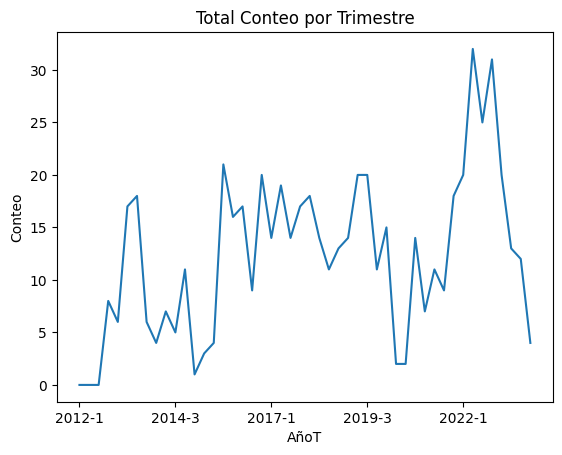

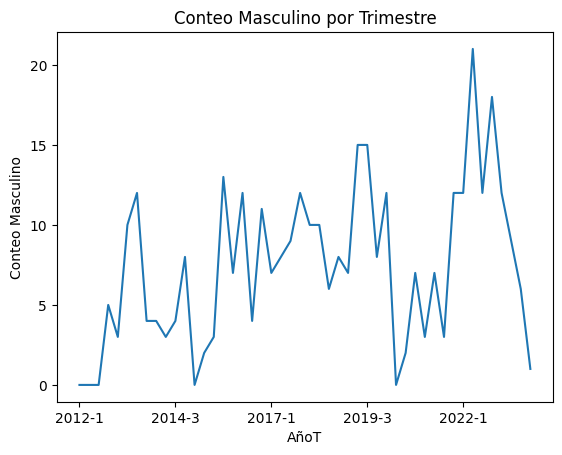

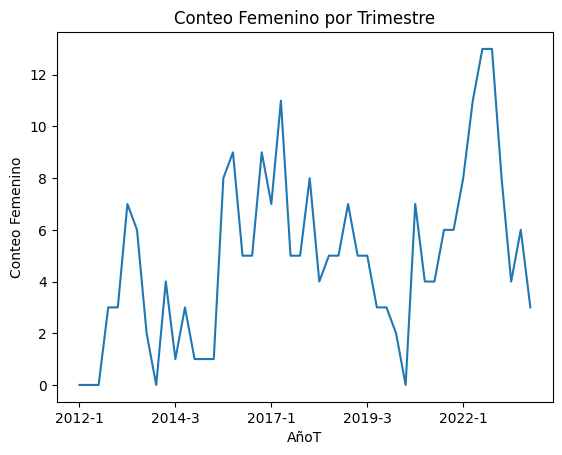

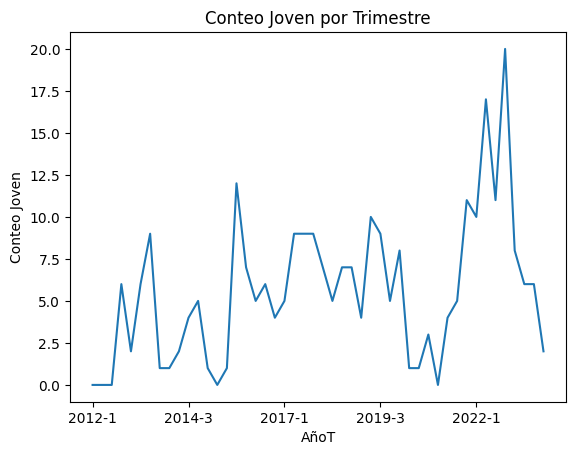

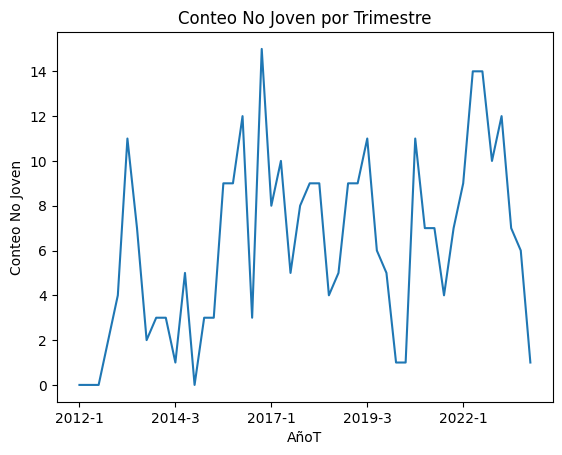

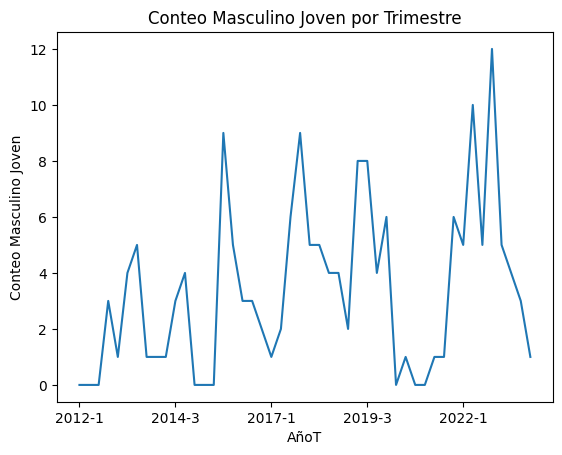

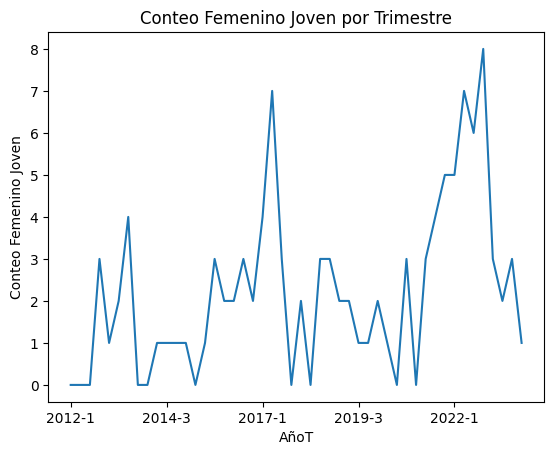

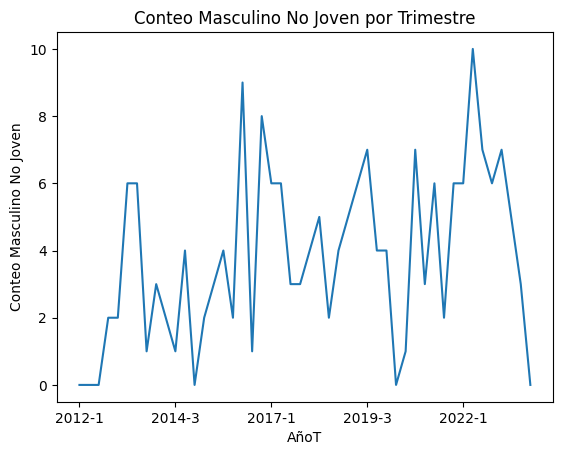

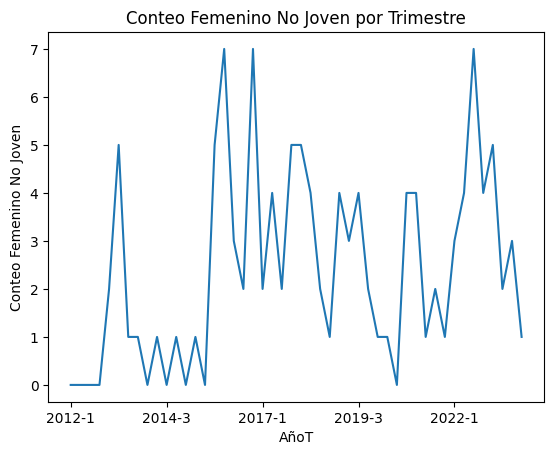

In [37]:
# Plot for Datos_conteo
Datos_conteo.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Total Conteo por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo')
plt.show()

# Plot for Datos_conteoM
Datos_conteoM.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino')
plt.show()

# Plot for Datos_conteoF
Datos_conteoF.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino')
plt.show()

# Plot for Datos_conteo_joven
Datos_conteo_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Joven')
plt.show()

# Plot for Datos_conteo_no_joven
Datos_conteo_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo No Joven')
plt.show()

# Plot for Datos_conteoM_joven
Datos_conteoM_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino Joven')
plt.show()

# Plot for Datos_conteoF_joven
Datos_conteoF_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino Joven')
plt.show()

# Plot for Datos_conteoM_no_joven
Datos_conteoM_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino No Joven')
plt.show()

# Plot for Datos_conteoF_no_joven
Datos_conteoF_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino No Joven')
plt.show()


In [38]:
def agregar_variables(df):
    estaciones_tratadas = ["ACEVEDO", "SAN ANTONIO", "SAN JAVIER"]
    periodos_2020 = [
        "2020-2", "2020-3", "2020-4",
        "2021-1", "2021-2", "2021-3", "2021-4",
        "2022-1", "2022-2", "2022-3", "2022-4",
        "2023-1", "2023-2", "2023-3", "2023-4"
    ]
    periodos_2022 = [
        "2022-1", "2022-2", "2022-3", "2022-4",
        "2023-1", "2023-2", "2023-3", "2023-4"
    ]
    df = df.copy()
    df["Treat"] = df["ESTACION"].isin(estaciones_tratadas).astype(int)
    df["Time2020"] = df["AñoT"].isin(periodos_2020).astype(int)
    df["Time2022"] = df["AñoT"].isin(periodos_2022).astype(int)
    df["TimeT2020"] = df["Treat"] * df["Time2020"]
    df["TimeT2022"] = df["Treat"] * df["Time2022"]
    return df

# 🔹 Lista con los nombres de todos los DataFrames
nombres = [
    "DatosV", "DatosM", "DatosF",
    "Datos_joven", "Datos_no_joven",
    "DatosM_joven", "DatosF_joven",
    "DatosM_no_joven", "DatosF_no_joven",
    "Datos_conteo", "Datos_conteoM", "Datos_conteoF",
    "Datos_conteo_joven", "Datos_conteo_no_joven",
    "Datos_conteoM_joven", "Datos_conteoF_joven",
    "Datos_conteoM_no_joven", "Datos_conteoF_no_joven"
]

# 🔹 Aplicar la función y actualizar en memoria global
for nombre in nombres:
    globals()[nombre] = agregar_variables(globals()[nombre])

Datos_conteoF
   

,ESTACION,AñoT,conteo,aprom,asum,Treat,Time2020,Time2022,TimeT2020,TimeT2022
0,ACEVEDO,2012-1,0,586976.666667,1760930,1,0,0,0,0
1,ACEVEDO,2012-2,0,591850.0,1775550,1,0,0,0,0
2,ACEVEDO,2012-3,0,617626.666667,1852880,1,0,0,0,0
3,ACEVEDO,2012-4,0,638917.666667,1916753,1,0,0,0,0
4,ACEVEDO,2013-1,0,586402.333333,1759207,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1291,UNIVERSIDAD,2022-4,1,NaN,NaN,0,1,1,0,0
1292,UNIVERSIDAD,2023-1,0,NaN,NaN,0,1,1,0,0
1293,UNIVERSIDAD,2023-2,0,NaN,NaN,0,1,1,0,0
1294,UNIVERSIDAD,2023-3,0,NaN,NaN,0,1,1,0,0


In [39]:


# 🔹 Conversión de "2012-1" → fecha (primer mes del trimestre)
def trimestre_to_date(tri: str) -> pd.Timestamp:
    año, t = map(int, tri.split('-'))
    mes = (t - 1) * 3 + 1
    return pd.Timestamp(year=año, month=mes, day=1)

# 🔹 Función para correr PanelOLS y devolver tabla organizada
def correr_panel_ols(df: pd.DataFrame, nombre: str = "DataFrame") -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    df = df.copy()
    df['AñoT_fecha'] = df['AñoT'].apply(trimestre_to_date)
    df_panel = df.set_index(['ESTACION', 'AñoT_fecha']).sort_index()

    try:
        modelo = PanelOLS.from_formula(
            "conteo ~ Treat + Time2020 + TimeT2020",
            data=df_panel,
            drop_absorbed=True
        )
        res = modelo.fit(cov_type="robust")
    except Exception as e:
        print(f"⚠️ Error en {nombre}: {e}")
        return pd.DataFrame()

    # Construir tabla organizada
    tabla = (
        pd.DataFrame({
            "Coeficiente": res.params,
            "Desv.Estándar": res.std_errors,
            "p-valor": res.pvalues
        })
        .T  # métricas como filas
    )

    # R² como fila adicional
    tabla.loc["R²"] = res.rsquared

    # Añadir identificador del modelo en índice
    tabla["Modelo"] = nombre
    tabla = tabla.set_index("Modelo", append=True).reorder_levels(["Modelo", None])

    return tabla

# 🔹 Bases a analizar
bases = {
    "Datos_conteo": Datos_conteo,
    "Datos_conteoM": Datos_conteoM,
    "Datos_conteoF": Datos_conteoF,
    "Datos_conteo_joven": Datos_conteo_joven,
    "Datos_conteo_no_joven": Datos_conteo_no_joven,
    "Datos_conteoM_joven": Datos_conteoM_joven,
    "Datos_conteoF_joven": Datos_conteoF_joven,
    "Datos_conteoM_no_joven": Datos_conteoM_no_joven,
    "Datos_conteoF_no_joven": Datos_conteoF_no_joven
}

# 🔹 Ejecutar todos y concatenar
resultados = [correr_panel_ols(df, nombre) for nombre, df in bases.items()]
tabla_final = pd.concat(resultados, axis=0)

# 🔹 Mostrar tabla final
tabla_final



Treat      Time2020  TimeT2020
Modelo                                                                     
Datos_conteo           Coeficiente    7.171717e-01  4.861111e-01  -0.203283
                       Desv.Estándar  1.011681e-01  4.500843e-02   0.232031
                       p-valor        2.217115e-12  0.000000e+00   0.381138
                       R²             1.631999e-01  1.631999e-01   0.163200
Datos_conteoM          Coeficiente    4.444444e-01  2.861111e-01  -0.241667
                       Desv.Estándar  7.323485e-02  3.377861e-02   0.137839
                       p-valor        1.690756e-09  0.000000e+00   0.079796
                       R²             1.109101e-01  1.109101e-01   0.110910
Datos_conteoF          Coeficiente    2.727273e-01  2.000000e-01   0.038384
                       Desv.Estándar  6.525359e-02  2.632417e-02   0.139378
                       p-valor        3.117896e-05  5.750955e-14   0.783058
                       R²             1.034543e-01  1.034543e-01   0.103454
Datos_conteo_joven     Coeficiente    3.131313e-01  2.277778e-01  -0.029798
                       Desv.Estándar  6.175630e-02  2.881015e-02   0.155141
                       p-valor        4.546507e-07  5.773160e-15   0.847718
                       R²             1.053554e-01  1.053554e-01   0.105355
Datos_conteo_no_joven  Coeficiente    3.737374e-01  2.500000e-01  -0.157071
                       Desv.Estándar  6.644583e-02  2.962775e-02   0.133290
                       p-valor        2.275190e-08  2.220446e-16   0.238848
                       R²             1.106194e-01  1.106194e-01   0.110619
Datos_conteoM_joven    Coeficiente    1.919192e-01  1.222222e-01  -0.091919
                       Desv.Estándar  3.962527e-02  2.092638e-02   0.082752
                       p-valor        1.430779e-06  6.573231e-09   0.266867
                       R²             5.888201e-02  5.888201e-02   0.058882
Datos_conteoF_joven    Coeficiente    1.212121e-01  1.055556e-01   0.062121
                       Desv.Estándar  4.113461e-02  1.714072e-02   0.102574
                       p-valor        3.269213e-03  9.805419e-10   0.544871
                       R²             7.204072e-02  7.204072e-02   0.072041
Datos_conteoM_no_joven Coeficiente    2.323232e-01  1.583333e-01  -0.123990
                       Desv.Estándar  5.318231e-02  2.359346e-02   0.098593
                       p-valor        1.351478e-05  2.886291e-11   0.208768
                       R²             7.444252e-02  7.444252e-02   0.074443
Datos_conteoF_no_joven Coeficiente    1.414141e-01  9.166667e-02  -0.033081
                       Desv.Estándar  4.047641e-02  1.713759e-02   0.086462
                       p-valor        4.923856e-04  1.045680e-07   0.702076
                       R²             5.040591e-02  5.040591e-02   0.050406

In [40]:

# Función para correr PanelOLS y devolver tabla organizada
def correr_panel_ols(df, nombre, formula):
    try:
        df = df.copy()
        df['AñoT_fecha'] = df['AñoT'].apply(trimestre_to_date)
        df_panel = df.set_index(['ESTACION', 'AñoT_fecha']).sort_index()
        modelo = PanelOLS.from_formula(formula, data=df_panel, drop_absorbed=True)
        res = modelo.fit(cov_type="robust")
        tabla = pd.DataFrame({
            "Coeficiente": res.params,
            "Desv.Estándar": res.std_errors,
            "p-valor": res.pvalues
        }).T
        tabla.loc["R²"] = res.rsquared
        tabla["Modelo"] = nombre
        tabla = tabla.set_index("Modelo", append=True).reorder_levels(["Modelo", None])
        return tabla
    except Exception as e:
        print(f"⚠️ Error en {nombre}: {e}")
        return pd.DataFrame()


resultados = []
for nombre, df in bases.items():
    # Puedes cambiar la fórmula según el análisis
    resultados.append(correr_panel_ols(df, nombre, "conteo ~ Treat + Time2022 + TimeT2022"))

tabla_final = pd.concat(resultados)
tabla_final


Treat      Time2022  TimeT2022
Modelo                                                                     
Datos_conteo           Coeficiente    7.500000e-01  6.822917e-01  -0.348958
                       Desv.Estándar  9.603509e-02  7.513398e-02   0.324137
                       p-valor        1.176836e-14  0.000000e+00   0.281871
                       R²             1.668592e-01  1.668592e-01   0.166859
Datos_conteoM          Coeficiente    4.583333e-01  4.166667e-01  -0.416667
                       Desv.Estándar  6.767175e-02  5.727903e-02   0.169321
                       p-valor        1.911182e-11  6.015188e-13   0.013992
                       R²             1.179654e-01  1.179654e-01   0.117965
Datos_conteoF          Coeficiente    2.916667e-01  2.656250e-01   0.067708
                       Desv.Estándar  5.945909e-02  4.345582e-02   0.198932
                       p-valor        1.051235e-06  1.296093e-09   0.733642
                       R²             1.022537e-01  1.022537e-01   0.102254
Datos_conteo_joven     Coeficiente    3.333333e-01  3.437500e-01  -0.093750
                       Desv.Estándar  5.938587e-02  4.816242e-02   0.225388
                       p-valor        2.430449e-08  1.581846e-12   0.677517
                       R²             1.159777e-01  1.159777e-01   0.115978
Datos_conteo_no_joven  Coeficiente    3.916667e-01  3.229167e-01  -0.256250
                       Desv.Estándar  6.276221e-02  4.890935e-02   0.164743
                       p-valor        5.900977e-10  5.892686e-11   0.120084
                       R²             1.042466e-01  1.042466e-01   0.104247
Datos_conteoM_joven    Coeficiente    1.833333e-01  1.979167e-01  -0.089583
                       Desv.Estándar  3.536354e-02  3.630610e-02   0.121149
                       p-valor        2.514598e-07  5.981613e-08   0.459771
                       R²             7.118237e-02  7.118237e-02   0.071182
Datos_conteoF_joven    Coeficiente    1.500000e-01  1.458333e-01  -0.004167
                       Desv.Estándar  4.196452e-02  2.755077e-02   0.134569
                       p-valor        3.638892e-04  1.410330e-07   0.975304
                       R²             6.894531e-02  6.894531e-02   0.068945
Datos_conteoM_no_joven Coeficiente    2.583333e-01  2.083333e-01  -0.300000
                       Desv.Estándar  5.074274e-02  3.890448e-02   0.099443
                       p-valor        4.087809e-07  1.011593e-07   0.002604
                       R²             7.206921e-02  7.206921e-02   0.072069
Datos_conteoF_no_joven Coeficiente    1.333333e-01  1.145833e-01   0.043750
                       Desv.Estándar  3.526499e-02  2.733404e-02   0.132588
                       p-valor        1.633904e-04  2.953537e-05   0.741476
                       R²             4.959877e-02  4.959877e-02   0.049599

In [41]:


def correr_poisson_y_ct_display(bases_dict, fe_unit="ESTACION", time_col="AñoT_fecha"):
    resumen_filas = []

    for nombre, df in bases_dict.items():
        df = df.copy()

        if 'conteo' not in df.columns:
            print(f"Omitiendo {nombre}: no tiene columna 'conteo'.")
            continue

        # --- Variables dependiente e independientes ---
        y = pd.to_numeric(df['conteo'], errors='coerce')
        X = df.loc[:, [c for c in ['Treat','TTime2020','TimeT2020'] if c in df.columns]].copy()
        X = X.apply(pd.to_numeric, errors='coerce')
        X = add_constant(X, has_constant='add')

        # --- Efectos fijos por unidad ---
        if fe_unit in df.columns:
            dummies = pd.get_dummies(df[fe_unit].astype(str), prefix=fe_unit, drop_first=True)
            dummies = dummies.astype(float)
            X_fe = pd.concat([X, dummies], axis=1)
        else:
            X_fe = X

        # --- Asegurar tipo numérico en todo X ---
        X_fe = X_fe.apply(pd.to_numeric, errors='coerce')
        X_fe = X_fe.fillna(0)

        # --- Ajustar modelo Poisson ---
        try:
            model = sm.GLM(y, X_fe, family=sm.families.Poisson())
            res = model.fit(disp=0, maxiter=200)
        except Exception as e:
            print(f"Error en {nombre}: {e}")
            continue

        # --- Dispersión de Pearson ---
        mu = res.fittedvalues
        pearson_chi2 = np.sum(((y - mu)**2) / (mu + 1e-20))
        df_resid = max(1, res.df_resid)
        dispersion_pearson = pearson_chi2 / df_resid

        # --- Cameron–Trivedi NB2 ---
        z = (y - mu)**2 - y
        X_nb2 = add_constant(pd.DataFrame({'mu2': mu**2}))
        aux_nb2 = sm.OLS(z, X_nb2).fit()
        coef_nb2 = aux_nb2.params.get('mu2', np.nan)
        p_nb2 = aux_nb2.pvalues.get('mu2', np.nan)

        # --- Cameron–Trivedi NB1 ---
        X_nb1 = add_constant(pd.DataFrame({'mu': mu}))
        aux_nb1 = sm.OLS(z, X_nb1).fit()
        coef_nb1 = aux_nb1.params.get('mu', np.nan)
        p_nb1 = aux_nb1.pvalues.get('mu', np.nan)

        resumen_filas.append({
            'base': nombre,
            'n_obs': int(res.nobs),
            'df_resid': float(df_resid),
            'dispersion_pearson': float(dispersion_pearson),
            'coef_nb2': float(coef_nb2),
            'p_nb2': float(p_nb2),
            'coef_nb1': float(coef_nb1),
            'p_nb1': float(p_nb1),
        })

    resumen_df = pd.DataFrame(resumen_filas)
    display(resumen_df)
    return resumen_df

# Ejecutar
resumen_resultados = correr_poisson_y_ct_display(bases)


,base,n_obs,df_resid,dispersion_pearson,coef_nb2,p_nb2,coef_nb1,p_nb1
0,Datos_conteo,1296,1268.0,1.173019,0.466407,9.131472e-08,0.594646,1.104915e-06
1,Datos_conteoM,1296,1268.0,1.106003,0.201031,1.509902e-01,0.185841,7.799070e-02
2,Datos_conteoF,1296,1268.0,1.036638,0.533489,4.181317e-03,0.365677,2.457525e-03
3,Datos_conteo_joven,1296,1268.0,1.054970,1.236077,6.575618e-13,0.648212,1.199864e-08
4,Datos_conteo_no_joven,1296,1268.0,1.013401,0.086943,4.065648e-01,0.061984,3.959510e-01
5,Datos_conteoM_joven,1296,1268.0,0.965436,0.175559,4.910918e-01,0.041862,6.152332e-01
6,Datos_conteoF_joven,1296,1268.0,1.018733,1.181764,6.482811e-10,0.348185,8.083113e-07
7,Datos_conteoM_no_joven,1296,1268.0,0.988873,0.138479,5.386739e-01,0.073583,4.388519e-01
8,Datos_conteoF_no_joven,1296,1268.0,0.976426,0.274332,2.892712e-01,0.068092,3.342792e-01
